<a href="https://colab.research.google.com/github/FrankGangWang/AppliedML_Python_Coursera/blob/master/Final_Interview_for_DataScience_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Interview questions to test data science skills**

---




# Let's load the data from public GitHub account

In [1]:
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
import seaborn as sns


In [141]:
# load data and check condation of NA
df = pd.read_pickle("https://github.com/manjiler/interview_for_datascience/raw/master/interview_storage.pkl")


In [ ]:
# check missing data; result: no missing data
print(f'*** There are {df.isna().sum().sum()} NA data')
df.info()
df.describe()

In [104]:
df.columns

Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds'],
      dtype='object')

## Now that the data is loaded. let's begin!!!

# **About the data**

---
This is time series data for one month collected for N number of devices

Columns

systemId - Device name

timestamp_seconds - epoch time when the sensor data was collected

model_type - Different versions/release/model of the device (similar to mobile models)

cpu_utilization - this percentage of how much the CPU is used on the device.

read_cache_miss - Percentage of read that were not present in the Cache

write_cache_miss - Percentage of write that were not present in the Cache

read_iops -  Number of read IOs per second (Input/Output)

write_iops -  Nummber of write IOs per second (Input/Output)

read_throughput - the read bandwidth per second (Units kbps)

write_throughput - the write bandwidth per second (Units kbps)

read_iosz - the block size for read Input/Output operations

write_iosz - the block size for write Input/Output operations


y -> cpu_utilization



## Q1. Do an EDA on the data, correlation plots, features that might be important for the modeling. Share your observations. Comment on how the data looks from modeling perspective

In [142]:
# RUN: add sorted datetime index
df['timestamp_seconds'] = df.pop('timestamp')/1.0e3
df.set_index(pd.to_datetime(df['timestamp_seconds'], unit='s', origin='unix'), inplace=True)
df.sort_index(inplace=True)

In [143]:
# add some artificial features maybe useful for classification
# add sin/cos for day/hour
# To help finding time periodicity (hourly/daily/weekly/monthly/yearly), 
#    add additional features like "time of day/week" by appling cos and sin to timestamp_seconds 
hour = 60*60
day = 24*hour
week = 7*day
df['Hour_Sin'] = np.sin(df['timestamp_seconds'] * (2 * np.pi / hour))
df['Hour_Cos'] = np.cos(df['timestamp_seconds'] * (2 * np.pi / hour))
df['Day_Sin'] = np.sin(df['timestamp_seconds'] * (2 * np.pi / day))
df['Day_Cos'] = np.cos(df['timestamp_seconds'] * (2 * np.pi / day))
week_offset = 3*day # as epoch 0 is Thursday 1970-01-01, and leap seconds 23:59:60
df['Week_Sin'] = np.sin((df['timestamp_seconds']+week_offset) * (2 * np.pi / week))
df['Week_Cos'] = np.cos((df['timestamp_seconds']+week_offset) * (2 * np.pi / week))

In [145]:
df[df['systemId']=='sys21'].head(5)

,systemId,model_type,cpu_utilization,read_cache_miss,write_cache_miss,read_iops,write_iops,read_throughput,write_throughput,read_iosz,write_iosz,timestamp_seconds,Hour_Sin,Hour_Cos,Day_Sin,Day_Cos,Week_Sin,Week_Cos
timestamp_seconds,,,,,,,,,,,,,,,,,,
2019-11-01 04:45:00,sys21,A,22.356520,60.522335,76.321373,35882.878906,14471.190430,1988486.875,354162.062500,55.417404,24.472218,1.572584e+09,-1.000000e+00,5.161339e-11,0.946930,0.321439,-0.586271,-0.810115
2019-11-01 04:50:00,sys21,A,24.533209,64.730011,74.525345,42838.578125,16502.996094,2101236.000,293132.031250,49.051243,17.762209,1.572584e+09,-8.660254e-01,5.000000e-01,0.953717,0.300706,-0.588793,-0.808284
2019-11-01 04:55:00,sys21,A,22.255287,65.644623,74.032097,40653.140625,11230.614258,2245472.750,205445.953125,55.233959,18.293446,1.572584e+09,-5.000000e-01,8.660254e-01,0.960050,0.279829,-0.591310,-0.806445
2019-11-01 05:00:00,sys21,A,23.559666,65.743530,73.571999,46550.292969,9845.186523,2324436.250,203527.921875,49.933792,20.672852,1.572584e+09,-9.157618e-12,1.000000e+00,0.965926,0.258819,-0.593820,-0.804598
2019-11-01 05:05:00,sys21,A,29.682507,71.264267,81.304985,64238.296875,16920.511719,2420107.250,364787.093750,37.673389,21.558887,1.572585e+09,5.000000e-01,8.660254e-01,0.971342,0.237686,-0.596325,-0.802743


In [146]:
# plot histogram of systemId_selected
def plot_df_hist(df_tmp, systemId_selected, title_str, cols, bins):
  if systemId_selected[0] != 'All':
    df_tmp = df_tmp[df_tmp['systemId']==systemId_selected[0]]
  df_tmp = df_tmp[cols]
  df_tmp.hist(bins=bins)
  fig = plt.gcf()
  fig.set_size_inches(18, 8)
  fig.suptitle(f'{title_str}, systemId {systemId_selected[0]}')
  plt.tight_layout()
  fig.subplots_adjust(top=0.9)


In [ ]:
# plot hist of all systemIds: a few columns are far from Gaussian distribution
#systemId_selected = ['sys1']
systemId_selected = ['All']
title_str = 'Before transformation!'
plot_df_hist(df, systemId_selected, title_str, df.columns, 30)
#NOTE: Hour_Sin AND Hour_Cos have  only 7 distinct bins for [0, 30, 60, 90, -30, -60, -90] degress as 
# as sampling perid=5 minutes, thus 2pi*5min/60min=pi/6=30degree
# Thus hist of Hour_Sin has!!!

The histograms show that we need apply normalization and power transformation


In [150]:
# utility hist2d plot xcols against target ycol
def hist2d_plot(df_temp, systemId, xcols, ycol, xbins, ybins, vmax):
  print(f"hist2d_plot 1 Initial address of df_temp: {id(df_temp)}, shape={df_temp.shape}")
  if systemId != 'All': 
    df_temp = df[df['systemId']==systemId]
  print(f"hist2d_plot 2 Initial address of df_temp: {id(df_temp)}, shape={df_temp.shape}")
  print(df_temp.shape)
  len_x = len(xcols)
  num_rows = math.ceil(math.sqrt(len_x))
  num_cols = math.ceil(len_x/num_rows)
  x_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      if x_index == len_x:
        break
      plt.subplot(num_rows, num_cols, x_index+1)
      plt.hist2d(df_temp[xcols[x_index]], df_temp[ycol], bins=[xbins, ybins], vmax=vmax) #
      plt.colorbar()
      plt.xlabel(xcols[x_index])
      plt.ylabel(ycol)
      x_index = x_index + 1
  fig = plt.gcf()
  fig.set_size_inches(18.5, 3*num_rows)
  fig.suptitle(f'systemId={systemId}')
  plt.tight_layout() # 2nd last step in fig setting
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()


In [ ]:
#  plot hist2d: xcols against target ycol
systemId_selected = 'All'
vmax = 100; xbins = 50; ybins = 50
ycol = 'cpu_utilization'
xcols_group = [
  ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops'],
  ['read_throughput', 'write_throughput', 'read_iosz', 'write_iosz'],
  ['Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']]
for xcols in xcols_group:
  hist2d_plot(df, systemId_selected, xcols, ycol, xbins, ybins, vmax)

In [ ]:
systemId_selected = 'sys1'
vmax = 100; xbins = 50; ybins = 50
ycol = 'read_throughput'
xcols_group = [
  ['write_throughput', 'read_iosz', 'write_iosz', 'read_cache_miss']]
for xcols in xcols_group:
  hist2d_plot(df, systemId_selected, xcols, ycol, xbins, ybins, vmax)

Compare hists of each single systemId ('sys1' vs 'sys2', etc) and single systemId with hist of all systemIds 'All' case:
1. each systemId has different hist patterns
2. Hour_Sin and Hour_Cos show a pattern at certain times per hour


In [152]:
df.columns

Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Week_Sin', 'Week_Cos'],
      dtype='object')

In [153]:
# Transform to make data more Gaussian-like 
# Standarize to make close Norml(0, 1)
# Only to numerical_transform_cols, not for timestamp, categoricals
def transform_features(df, systemId_selected, numerical_transform_cols):
  from sklearn.preprocessing import PowerTransformer
  #from sklearn.preprocessing import QuantileTransformer
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  print(f'*** Inside transform_features(): df_tmp.shape={df_tmp.shape}')
  # Start Transformation
  data = df_tmp.values
  power = PowerTransformer(method='box-cox', standardize=True)
  data = power.fit_transform(data)
  # convert the array back to a dataframe
  df_tmp = pd.DataFrame(data, columns=numerical_transform_cols)
  # histogram of the transformed data
  print(f'*** After transform_features(): dataset.shape={df_tmp.shape}')
  return data, power

In [154]:
# RUN: LabelEncoder + OneHotEncoder for categorical columns
# return np.array oflabel encoded data and encoders
def label_encode(df_in, systemId_selected, cols_to_encode):
  from sklearn.preprocessing import LabelEncoder
  from sklearn.preprocessing import OneHotEncoder
  if systemId_selected[0] == 'All':
    df = df_in
  else:  
    df = df_in[df_in['systemId']==systemId_selected[0]]
  print(f'inside label_encode: systemId={systemId_selected}, df shape={df.shape}')
  first_col = True
  label_encoders = []
  my_onehot_encoders = []
  for col in cols_to_encode:
    label_encoder = LabelEncoder()
    X = df[col].values
    X = label_encoder.fit_transform(X)
    label_encoders.append({col:label_encoder})
    print(f'******Inside label_encode: just after fit_transform 1: col={col}, X.shape={X.shape}')
    X = X.reshape(X.shape[0], 1)
    print(f'******Inside label_encode: just after fit_transform 2: col={col}, X.shape={X.shape}')
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    X = onehot_encoder.fit_transform(X)
    print(f'******Inside label_encode: just after my_OneHotEncoder: col={col}, X.shape={X.shape}')
    print(f'******Inside label_encode: just after my_OneHotEncoder: col={col}, onehot_encoder={onehot_encoder}')
    if first_col:
      data = X
      print(f'first_col={first_col}, col={col}, X.shape={X.shape}, data.shape={data.shape}')
      first_col = False
    else:        
      data = np.concatenate((data, X), axis=1)
      print(f'first_col={first_col}, col={col}, X.shape={X.shape}, data.shape={data.shape}')
  return data, label_encoders, my_onehot_encoders

In [155]:
def minmax_scaler_time(df, systemId_selected, cols):
  from sklearn.preprocessing import MinMaxScaler
  if systemId_selected[0] == 'All':
    df_tmp = df[cols].values
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][cols].values
  minmax_scaler = MinMaxScaler()
  df_tmp = minmax_scaler.fit_transform(df_tmp)
  return df_tmp

In [156]:
df.columns

Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Week_Sin', 'Week_Cos'],
      dtype='object')

In [157]:
# Pipeline common settings: 
# compare correlation before AND after transformation to normalize distribution
# Constants: 
# size of data for train, cross validation, test
SINGLE_SYSTEM_ID = 'sys1'
TEST_SIZE = 0.2 # Not yet used; TODO
SINGLE_SYSTEM_MODLE = True # if False then need OneHotEncoder to categorical features ['systemId' and 'model_type']
USE_TIME_TRANSFORMED = True # NOTE: PowerTransform only accept positive input
USE_TIME_STAMP = True
numerical_transform_cols = ['cpu_utilization',
       'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
time_transformed_cols = [ 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']
cols_to_encode = ['systemId', 'model_type']
if SINGLE_SYSTEM_MODLE:
  systemId_selected = [SINGLE_SYSTEM_ID]
else:
  systemId_selected = ['All']

# timestamp_seconds is appended after numerical_transform_cols are added to data
TIMESTAMP_INDEX_DATA = len(numerical_transform_cols) 


In [158]:
# Step 1.2: transform AND standarization FOR numerical_transform_cols
# MUST first use numerical_transform_cols THEN use cols_to_encode
# MUST NOT transform timestamp_seconds !!! 

data, power = transform_features(df, systemId_selected, numerical_transform_cols)
data_cols = numerical_transform_cols
print(f'After transform_features call, data shape={data.shape}')
print(f'data_cols len={len(data_cols)}, \n data_cols={data_cols}')


*** Inside transform_features(): df_tmp.shape=(7926, 9)
*** After transform_features(): dataset.shape=(7926, 9)
After transform_features call, data shape=(7926, 9)
data_cols len=9, 
 data_cols=['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']


In [159]:
if USE_TIME_STAMP:
  data_cols = data_cols + ['timestamp_seconds']
  data_new = minmax_scaler_time(df, systemId_selected, ['timestamp_seconds'])
  print(f'After concatenate_features call 1, data shape={data.shape}, data_new shape={data_new.shape}')
  data = np.concatenate((data, data_new), axis=1)
  print(f'After concatenate_features call 2, data shape={data.shape}, data_new shape={data_new.shape}')
  print(f'data_cols len={len(data_cols)}, \n data_cols={data_cols}')


After concatenate_features call 1, data shape=(7926, 9), data_new shape=(7926, 1)
After concatenate_features call 2, data shape=(7926, 10), data_new shape=(7926, 1)
data_cols len=10, 
 data_cols=['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds']


In [ ]:
plt.subplot(2,1,1)
plt.plot(data[:, TIMESTAMP_INDEX_DATA])
plt.subplot(2,1,2)
plt.plot(data[:, TIMESTAMP_INDEX_DATA], data[:, 0])


In [161]:
# step 1.1: MinMax timestamp_seconds, not StandardScaler
# timestamp_seconds will be mapped to data[:,9] AND X[:,8]
if USE_TIME_TRANSFORMED:
  data_cols = data_cols + time_transformed_cols
  data_new = minmax_scaler_time(df, systemId_selected, time_transformed_cols)
  print(f'Before concatenate_features call, data shape={data.shape}, data_new shape={data_new.shape}')
  data = np.concatenate((data, data_new), axis=1)
  print(f'After concatenate_features call, data shape={data.shape}, data_new shape={data_new.shape}')
  print(f'data_cols len={len(data_cols)}, \n data_cols={data_cols}')


Before concatenate_features call, data shape=(7926, 10), data_new shape=(7926, 6)
After concatenate_features call, data shape=(7926, 16), data_new shape=(7926, 6)
data_cols len=16, 
 data_cols=['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']


In [ ]:
data_cols

In [ ]:
# check time transformations are all right
plt.rcParams['figure.figsize'] = (38, 6)
plt.figure()
plt.subplot(3,1,1)
plt.plot(data[:, TIMESTAMP_INDEX_DATA], data[:, 10],)
plt.subplot(3,1,2)
plt.plot(data[:, TIMESTAMP_INDEX_DATA], data[:, 12])
plt.subplot(3,1,3)
plt.plot(data[:, TIMESTAMP_INDEX_DATA], data[:, 14])


In [164]:
# Step 2: label encoder categorical columns (model_type only) (sysemId)
# concatenate new data
# WARNING: only run once to avoid add the same columns more than 1 times
data_new, label_encoders, my_onehot_encoders = label_encode(df, systemId_selected, cols_to_encode)
print(f'After label_encode call, data_new shape={data_new.shape}')
data = np.concatenate((data, data_new), axis=1)
print(f'After concatenate, data shape={data.shape}')
data_cols = data_cols + cols_to_encode
print(f'data_cols len={len(data_cols)}, \n data_cols={data_cols}')

# Step 3: add Hour/Day/Week/Month/Year using Sin and Cos
# Step 4: add nonlinear relatonship between features



inside label_encode: systemId=['sys1'], df shape=(7926, 18)
******Inside label_encode: just after fit_transform 1: col=systemId, X.shape=(7926,)
******Inside label_encode: just after fit_transform 2: col=systemId, X.shape=(7926, 1)
******Inside label_encode: just after my_OneHotEncoder: col=systemId, X.shape=(7926, 1)
******Inside label_encode: just after my_OneHotEncoder: col=systemId, onehot_encoder=OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)
first_col=True, col=systemId, X.shape=(7926, 1), data.shape=(7926, 1)
******Inside label_encode: just after fit_transform 1: col=model_type, X.shape=(7926,)
******Inside label_encode: just after fit_transform 2: col=model_type, X.shape=(7926, 1)
******Inside label_encode: just after my_OneHotEncoder: col=model_type, X.shape=(7926, 1)
******Inside label_encode: just after my_OneHotEncoder: col=model_type, onehot_encoder=OneHotEncoder(categories='auto', drop=None, d

In [77]:
print(f'data_cols len={len(data_cols)}, \n data_cols={data_cols}')

data_cols len=18, 
 data_cols=['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos', 'systemId', 'model_type']


In [ ]:
NUM_SPLITS = 10
NUM_EPOCHS = 100
BATCH_SIZE = 10

# Regression
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = data[:,1:]
Y = data[:, 0]

# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(18, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
	model.add(Dense(8, kernel_initializer='normal', activation='relu'))
	model.add(Dense(8, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
  
# Step: evaluate model with standardized dataset
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits = NUM_SPLITS) # shuffle=False
#results = cross_val_score(pipeline, X, Y, cv=kfold)
print(f'X shape={X.shape}, Y shape = {Y.shape}')
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
print(results)

from sklearn.model_selection import cross_val_predict
# TRY this also
#from sklearn import linear_model

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(pipeline, X, Y, cv=kfold)
fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid()
plt.show()


X shape=(7926, 17), Y shape = (7926,)
Epoch 1/100
714/714 [==============================] - 2s 1ms/step - loss: 0.4350
Epoch 2/100
714/714 [==============================] - 1s 1ms/step - loss: 0.0549
Epoch 3/100
714/714 [==============================] - 1s 1ms/step - loss: 0.0456
Epoch 4/100
714/714 [==============================] - 1s 1ms/step - loss: 0.0450
Epoch 5/100
714/714 [==============================] - 1s 1ms/step - loss: 0.0440
Epoch 6/100
714/714 [==============================] - 1s 1ms/step - loss: 0.0440
Epoch 7/100
714/714 [==============================] - 1s 1ms/step - loss: 0.0434
Epoch 8/100
714/714 [==============================] - 1s 1ms/step - loss: 0.0414
Epoch 9/100
714/714 [==============================] - 1s 1ms/step - loss: 0.0429
Epoch 10/100
714/714 [==============================] - 1s 1ms/step - loss: 0.0396
Epoch 11/100
714/714 [==============================] - 1s 1ms/step - loss: 0.0396
Epoch 12/100
714/714 [==============================] - 1s

In [ ]:
print(X.shape,Y.shape, type(X))
plt.plot(X[:, 8])


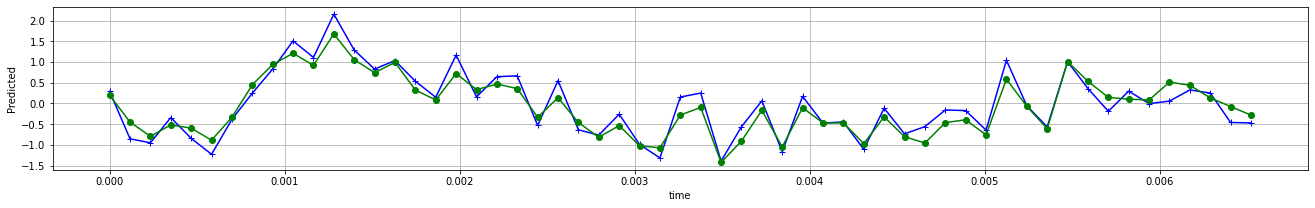

In [80]:
# plot against time
def plot_prediction_time(start, stop, X, Y, predicted):
  fig, ax = plt.subplots()
  ax.plot(X[start:stop, TIME_INDEX_IN_X], Y[start:stop], 'b-+')
  ax.plot(X[start:stop, TIME_INDEX_IN_X], predicted[start:stop], 'g-o')
  #ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
  ax.set_xlabel('time')
  ax.set_ylabel('Predicted')
  ax.grid()
  fig.set_size_inches(22.5, 3)
  plt.show()
  predicted.shape

TIME_INDEX_IN_X = 8
#TIME_INDEX_IN_DATA = 9 as X=data[:, 1:]
start= int(0*24*60/5)
stop = int(0.2*24*60/5)
plot_prediction_time(start, stop, X, Y, predicted)


In [ ]:
print(data.shape, len(numerical_transform_cols))
print(len(numerical_transform_cols), len(cols_to_encode))
print(numerical_transform_cols)


(7926, 18) 10
10 2
['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp']


In [81]:
# RUN: inverse_transform target estimated
REPEATED_TIMES = len(numerical_transform_cols)
print(predicted.shape)
y1 = predicted.reshape(predicted.shape[0], 1)
print(y1.shape)
y1 = y1.repeat(REPEATED_TIMES, axis=1)
y_hat = power.inverse_transform(y1)
print(y1.shape, y_hat.shape)


(7926,)
(7926, 1)
(7926, 9) (7926, 9)


In [82]:
# transform and standarize to make data more Gaussian-like 
def get_target(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  return df_tmp.values

y_real = get_target(df, systemId_selected, 'cpu_utilization' )


In [ ]:
print(y_real.shape, y_hat.shape)


(175505,) (175505, 9)


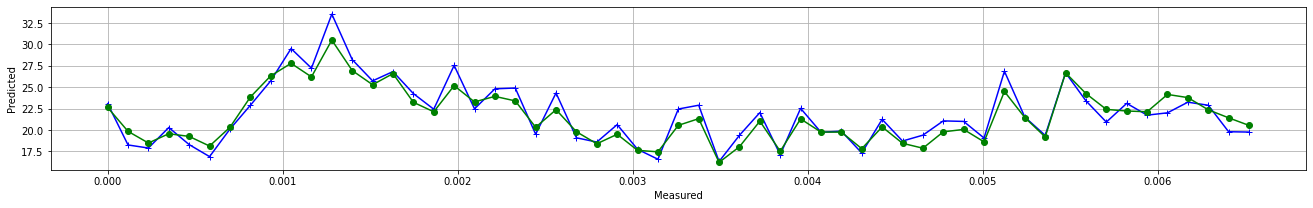

(7926,)

In [83]:
#plot inverse transformed y_hat against time
fig, ax = plt.subplots()
start= int(0*24*60/5)
stop = int(0.2*24*60/5)

ax.plot(X[:, TIME_INDEX_IN_X][start:stop], y_real[start:stop], 'b-+')
ax.plot(X[:, TIME_INDEX_IN_X][start:stop], y_hat[:, 0][start:stop], 'g-o')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 3)
plt.show()
predicted.shape

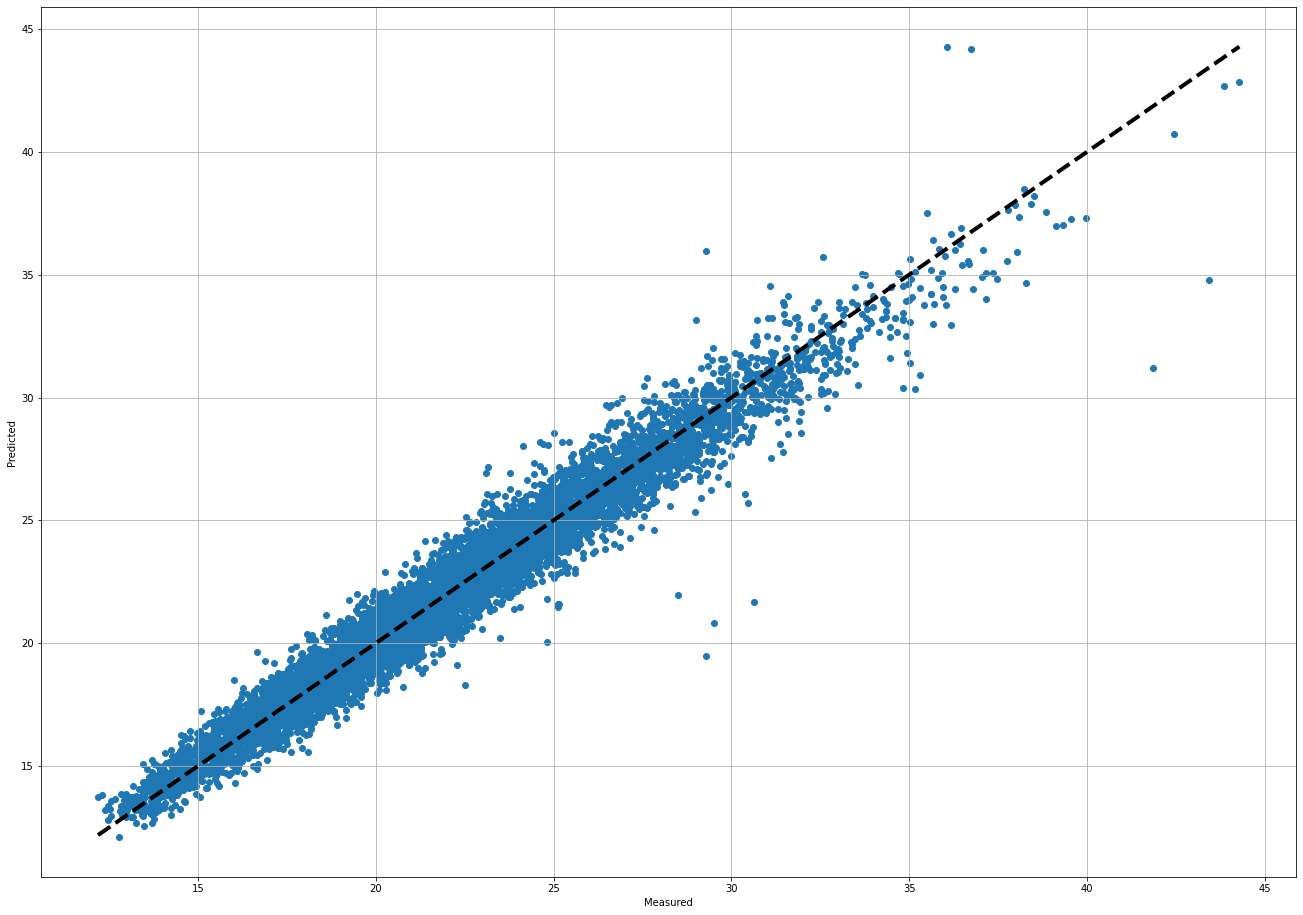

(7926,)

In [84]:

fig, ax = plt.subplots()
ax.scatter(y_real, y_hat[:, 0])
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 16)
plt.show()
predicted.shape


Finished regression here

In [ ]:
# Run this after Standardarization
# Add nonlinear transformation of features
df['rw_cache_miss_ratio'] = df['read_cache_miss'] / df['write_cache_miss']
df['rw_iops_ratio'] = df['read_iops'] / df['write_iops']
df['rw_throughput_ratio'] = df['read_throughput'] / df['write_throughput']
df['rw_iosz_ratio'] = df['read_iosz'] / df['write_iosz']

df['rw_cache_miss_diff'] = df['read_cache_miss'] - df['write_cache_miss']
df['rw_iops_diff'] = df['read_iops'] - df['write_iops']
df['rw_throughput_diff'] = df['read_throughput'] - df['write_throughput']
df['rw_iosz_diff'] = df['read_iosz'] - df['write_iosz']

In [87]:
# RUN: pairplotr VERY SLOW for larger number of features! !!
def pairplot(df, systemId_selected, cols, title_str):
  if len(systemId_selected)>0:
    df = df[df['systemId']==systemId_selected]
  sns.pairplot(df[cols], corner=True)
  fig = plt.gcf()
  fig.set_size_inches(15.5, 3*2)
  fig.suptitle(f'{title_str}, systemId {systemId_selected[0]}')
  plt.show()

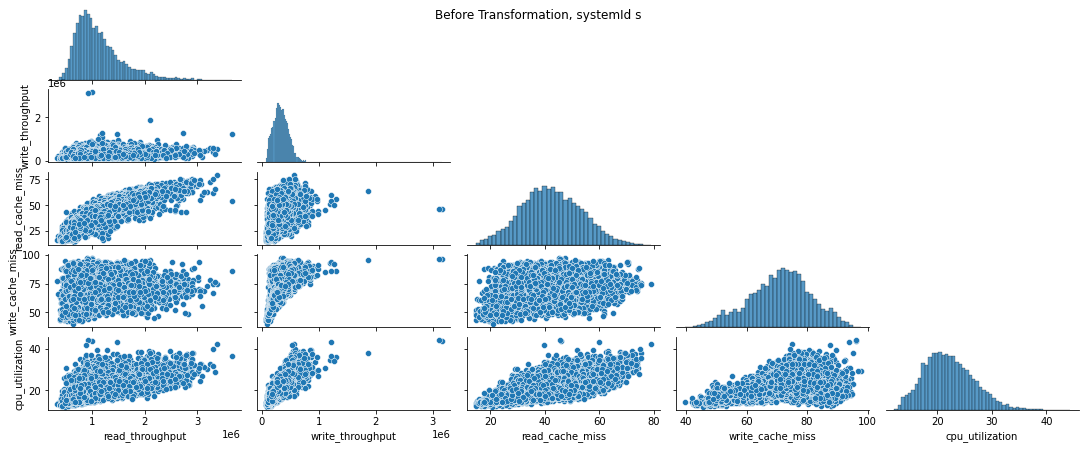

In [90]:
systemId = 'sys1'
cols = [['read_throughput', 'write_throughput', 'read_cache_miss', 'write_cache_miss', 'cpu_utilization'] ,
        ['read_iops', 'write_iops', 'read_iosz', 'write_iosz','cpu_utilization'],
        ['rw_cache_miss_ratio', 'rw_iops_ratio', 'rw_throughput_diff', 'rw_iosz_diff', 'cpu_utilization'], 
        ['write_throughput_DayCos', 'write_throughput_HourCos', 'cpu_utilization']]

title_str = 'Before Transformation'
pairplot(df, systemId, cols[0], title_str)

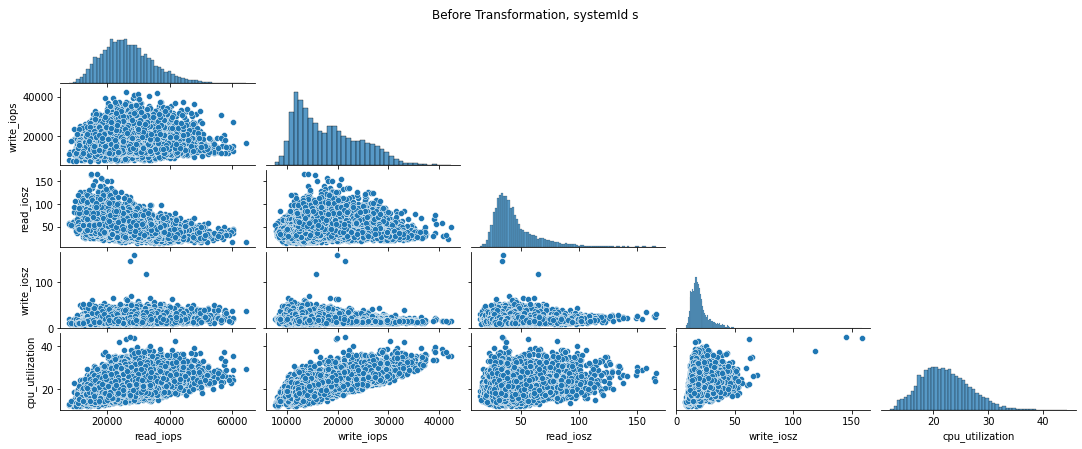

In [92]:
title_str = 'Before Transformation'
pairplot(df, systemId, cols[1], title_str)

In [95]:
print(f' data.shape={data.shape}, data_cols len={len(data_cols)}\n data_cols={data_cols}')


 data.shape=(7926, 18), data_cols len=18
 data_cols=['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos', 'systemId', 'model_type']


In [104]:
# RUN: feature selection based on correlation  
# NOTE: this is done separately for each of systemId, not for all systemIds altogether
#label encoder for model
def select_feature_by_correlation(data, data_cols, corr_threshold):
  df = pd.DataFrame(data, columns=data_cols)
  corr = df.corr()
  columns = np.full((corr.shape[0],), True, dtype=bool)
  for i in range(corr.shape[0]):
      for j in range(i+1, corr.shape[0]):
          if corr.iloc[i,j] >= corr_threshold:
              if columns[j]:
                  columns[j] = False
  selected_columns = df.columns[columns]
  removed_columns = [x for x in df.columns if x in selected_columns]
  removed_columns = [x for x in df.columns if x not in selected_columns]

  print(f'*** type corr_threshold={type(corr)}')
  print(f'df shape={df.shape}; corr shape={corr.shape}; systemId={systemId}')
  print(f'corr={corr}\n')
  print(f'systemId={systemId};')
  print(f'selected_columns={selected_columns}')
  print(f'removed_columns={removed_columns}')
  return selected_columns, corr

In [105]:
# RUN: feature selection based on correlation  
corr_threshold=0.8;
pd.set_option('display.max_columns', None)
selected_columns, corr = select_feature_by_correlation(data, data_cols, corr_threshold)

*** type corr_threshold=<class 'pandas.core.frame.DataFrame'>
df shape=(7926, 18); corr shape=(18, 18); systemId=sys1
corr=                   cpu_utilization  read_cache_miss  write_cache_miss  \
cpu_utilization           1.000000         0.636348          0.451695   
read_cache_miss           0.636348         1.000000          0.253870   
write_cache_miss          0.451695         0.253870          1.000000   
read_iops                 0.388049         0.434719          0.267662   
write_iops                0.752087         0.206712          0.093395   
read_throughput           0.522006         0.862791          0.107571   
write_throughput          0.817047         0.399167          0.656955   
read_iosz                 0.179495         0.482730         -0.133179   
write_iosz                0.291353         0.320716          0.709189   
timestamp_seconds        -0.196569        -0.202882         -0.222075   
Week_Sin                  0.141783         0.001960          0.075771   
W

In [106]:
selected_columns

Index(['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops',
       'write_iops', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos',
       'systemId', 'model_type'],
      dtype='object')

In [109]:
corr['read_throughput'].T

cpu_utilization      0.522006
read_cache_miss      0.862791
write_cache_miss     0.107571
read_iops            0.482019
write_iops           0.072865
read_throughput      1.000000
write_throughput     0.246023
read_iosz            0.594804
write_iosz           0.260125
timestamp_seconds   -0.033685
Week_Sin            -0.094522
Week_Cos            -0.020824
Day_Sin             -0.036255
Day_Cos              0.102384
Hour_Sin             0.105029
Hour_Cos            -0.008035
systemId                  NaN
model_type                NaN
Name: read_throughput, dtype: float64

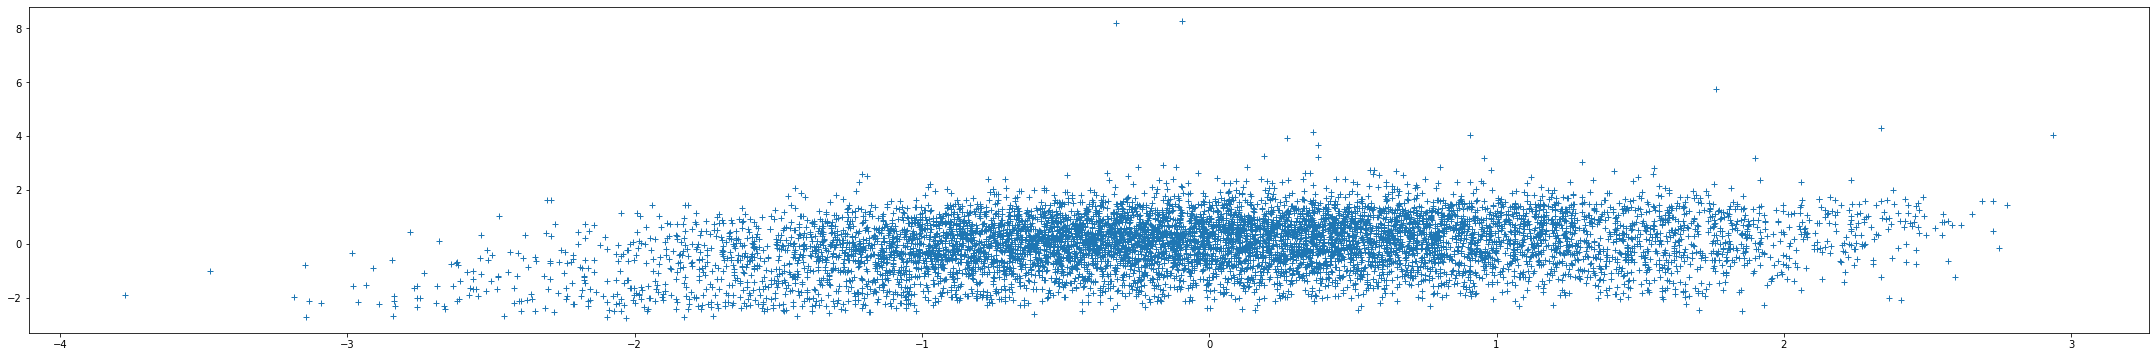

In [114]:
plt.plot(data[:, 5], data[:, 6], '+')

In [110]:
data_cols

['cpu_utilization',
 'read_cache_miss',
 'write_cache_miss',
 'read_iops',
 'write_iops',
 'read_throughput',
 'write_throughput',
 'read_iosz',
 'write_iosz',
 'timestamp_seconds',
 'Week_Sin',
 'Week_Cos',
 'Day_Sin',
 'Day_Cos',
 'Hour_Sin',
 'Hour_Cos',
 'systemId',
 'model_type']

In [ ]:
# compare a single selected systemId AGAINST whole systemIds
systemId_selected = ['sys1']
plot_corr(df, systemId_selected)

In [ ]:
def plot_corr(df, systemId_selected):
  if systemId_selected[0] == 'All':
    df_tmp = df
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]]
  sns.set_theme(style="white")
  # Compute the correlation matrix
  corr = df_tmp.corr()
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(15, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
  f.suptitle(f'systemId {systemId_selected[0]}')

  

In [ ]:
systemId_selected = ['sys1']
plot_corr(df, systemId_selected)


**Observation** 
After comparison Correlation plots of two cases:
-- Case_SINGLE: Only extract a single systemId (here 'sys1') case; 
-- Case_ALL:  Use all systemIds as a whole;

Conclusion:
1. timestamp_seconds has low correlation with all the rest features; and is less useful directly;
2. Day_Cos and Day_Sin have good correlation with a few columns and shall help prediction;


Case_SINGLE clearly exposes a larger nuber of columns having high correlations with the target 'cpu_utilization' than  that of Case_ALL. 

1.1 columns having good correlation with 'cpu_utilization':
Case_SINGLE: ['write_throughput', 'write_iops', 'read_cache_miss', 'read_throughput', 'read_iops', 'write_cache_miss']

Case_ALL: ['read_throughput', 'read_cache_miss'] 
['write_cache_miss',  'read_iops', 'write_throughput', 'write_iosz' ]

1.1 columns having good correlation with Day_sin:  
Case_SINGLE ['write_cache_miss', 'read_iops', 'write_iosz' ]
Case_ALL: None

1.2 Day_Cos has good correlation with 2 columns:
Case_SINGLE: ['write_iops', 'read_iosz']
Case_ALL: None





In [ ]:
df.columns

In [ ]:
systemId_selected = ['All']
plot_corr(df, systemId_selected)

In [ ]:
# normalize, average, and plot

def plot_columns_average(df, AVERAGE_METHOD, Window_Length):
  df1 = df[df['systemId']=='sys1']

  start_hour = 24*1+15;
  interval_hour= 24*20 + 10
  start = int(start_hour*hour/(5*60))
  stop = int((start_hour + interval_hour)*hour/(5*60))

  #x = df1['timestamp_seconds']
  df1['iops_rw_diff'] = df1['read_iops'] - df1['write_iops']
  df1['iops_rw_ratio'] = df1['read_iops']/df1['write_iops']

  df1['throughput_rw_diff'] = df1['read_throughput'] - df1['write_throughput']
  df1['throughput_rw_ratio'] = df1['read_throughput'] / df1['write_throughput']

  cols = ['write_cache_miss',  'read_iops', 'write_iosz', 'cpu_utilization', 'read_cache_miss', 
          'read_iosz', 'read_throughput', 'write_throughput', 'throughput_rw_diff', 'throughput_rw_ratio',
          'write_iops', 'iops_rw_diff', 'iops_rw_ratio', 'Day_Sin', 'Week_Sin']#, 'Hour_Sin']

  ### moving average and standarization
  cols_to_avg = ['cpu_utilization', 'read_cache_miss', 'write_cache_miss',
                'read_iosz', 'write_iosz', 'read_throughput', 'write_throughput', 'read_iops',
          'write_iops','throughput_rw_diff', 'throughput_rw_ratio', 'iops_rw_diff', 'iops_rw_ratio']

  for f in cols_to_avg:
    if AVERAGE_METHOD == 'rolling_moving_average':
      df1[f] = df1[f].rolling(window=Window_Length).mean()
    elif AVERAGE_METHOD == 'exponential_moving_average':
      df1[f] = df1[f].ewm(span=Window_Length, adjust=False).mean()
    elif AVERAGE_METHOD == 'cumulative_average': 
      df1[f] = df1[f].expanding(min_periods=Window_Length, adjust=False).mean()
    else:
      raise ValueError(f'AVERAGE_METHOD ={AVERAGE_METHOD} is not implemented!')
        
  cols_normalization = ['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iosz', 'write_iosz', 
                        'read_throughput', 'write_throughput', 'read_iops',
          'write_iops', 'throughput_rw_diff', 'throughput_rw_ratio', 'iops_rw_diff', 'iops_rw_ratio']

  from sklearn.preprocessing import StandardScaler
  autoscaler = StandardScaler()
  df1.loc[:, cols_normalization] = autoscaler.fit_transform(df1.loc[:, cols_normalization])

  x = df1['datetime']
  linepattern = '-+'
  fig = 1
  num_cols = len(cols)
  for f in cols:
    y = df1[f]
    plt.subplot(num_cols, 1, fig)
    plt.plot(x[start:stop], y[start:stop], linepattern)
    if f == 'write_iops' or f=='read_iosz':
      plt.plot(x[start:stop], df1['Day_Cos'][start-60:stop-60], 'g-o')
    else:
      plt.plot(x[start:stop], df1['Day_Sin'][start-60:stop-60], 'g-o')

    #plt.plot(x[start:stop], df1['Day_Cos'][start:stop], 'y-')
    plt.ylabel(f)
    fig= fig+1
    plt.grid(True)

  fig = plt.gcf()
  fig.set_size_inches(22.5, num_cols*3)



In [ ]:
# most sampling periods are 5 min, so window in mins is Window_Length*5 mins
# when Window_Length = int(2*60/5) in samples, it is in time interval of 120min=2hr
Window_Length = int(2*60/5) 

AVERAGE_METHOD_LIST = ['rolling_moving_average', 'exponential_moving_average', 'cumulative_average']
AVERAGE_METHOD = AVERAGE_METHOD_LIST[1] 
plot_columns_average(df, AVERAGE_METHOD, Window_Length)


In [ ]:
# check outliers; conclusion: no apparent outliers
df_stat = df.describe().T
df_stat['50% to 75%'] = (df_stat['50%']/df_stat['75%'])
df_stat['max to 75%'] = (df_stat['max']/df_stat['75%'])
df_stat

In [ ]:
print(f" df.shape={df.shape},\n df.columns={df.columns}")
sysIDs = np.unique(df['systemId'])
print(f" sysIDs shape={sysIDs.shape},\n sysIDs={sysIDs}")
model_types = np.unique(df['model_type'])
print(f" model_types shape={model_types.shape}, model_types ={model_types}")

In [ ]:
print((np.unique(df['model_type'])))
for sysId in np.unique(df['systemId']):
  data = df[df['systemId']==sysId]
  x = np.unique(data['model_type'])
  print(f'sysId={sysId}, {x}')


In [ ]:
# GANG WANG
# RUN this: select feature based on p-value

systemId = 'sys1'
data = df[df['systemId']==systemId]
print(np.unique(data['model_type'])

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


columns_to_scale=['timestamp_seconds', 'cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
autoscaler = StandardScaler()
data[columns_to_scale] = autoscaler.fit_transform(data[columns_to_scale])

y_column = ['cpu_utilization']; 
x_columns = ['timestamp_seconds', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz'] #, 'datetime']

x_in = data[x_columns].values
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
label_encoder2 = LabelEncoder()
data['model_type'] = label_encoder2.fit_transform(data['model_type'])
feature = data['model_type'].values
print("feature shape BEFORE reshape:", feature.shape)
feature = feature.reshape(feature.shape[0], 1)
print("feature shape AFTER reshape:", feature.shape)

print("x_in shape BEFORE one-hot-encoder:", x_in.shape)

feature = onehot_encoder.fit_transform(feature)
print(f'feature shape={feature.shape}')
x_in = np.concatenate((x_in, feature), axis=1)
print("x_in shape AFTER one-hot-encoder: : ", x_in.shape)


y_in = data[y_column].values
selected_columns = ['timestamp_seconds', 'read_cache_miss', 'write_cache_miss', 'read_iops',
                    'write_iops', 'read_throughput', 'write_throughput', 'read_iosz',
                    'write_iosz', 'model_type'] #, 'datetime']

import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    print(f'x={x[:2,:]}')
    print(f'Y={Y[:2]}')
    print(f'len(x[0]) = {len(x[0])}')
    print(f'x shape = {x.shape}')

    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
        print(f'**** backwardElimination i={i}, p-values={regressor_OLS.pvalues}')
        print(f'inside loop: x shape = {x.shape}')
                    
    print(regressor_OLS.summary())
    return x, columns

SL = 0.05
data_modeled, selected_columns = backwardElimination(x_in, y_in, SL, selected_columns)


In [ ]:
def old_OneHotEncoder():
  systemId = 'sys1'
  data = df[df['systemId']==systemId]
  print(np.unique(data['model_type'])

  columns_to_scale=['timestamp_seconds', 'cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
  autoscaler = StandardScaler()
  data[columns_to_scale] = autoscaler.fit_transform(data[columns_to_scale])

  y_column = ['cpu_utilization']; 
  x_columns = ['timestamp_seconds', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz'] #, 'datetime']

  x_in = data[x_columns].values
  onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
  label_encoder2 = LabelEncoder()
  data['model_type'] = label_encoder2.fit_transform(data['model_type'])
  feature = data['model_type'].values
  print("feature shape BEFORE reshape:", feature.shape)
  feature = feature.reshape(feature.shape[0], 1)
  print("feature shape AFTER reshape:", feature.shape)

  print("x_in shape BEFORE one-hot-encoder:", x_in.shape)

  feature = onehot_encoder.fit_transform(feature)
  print(f'feature shape={feature.shape}')
  x_in = np.concatenate((x_in, feature), axis=1)
  print("x_in shape AFTER one-hot-encoder: : ", x_in.shape)


  y_in = data[y_column].values
  selected_columns = ['timestamp_seconds', 'read_cache_miss', 'write_cache_miss', 'read_iops',
                      'write_iops', 'read_throughput', 'write_throughput', 'read_iosz',
                      'write_iosz', 'model_type'] #, 'datetime']


In [ ]:
# RUN this: utility function for plotting x vs y for a selected systemId  
# x MUST be a list with a SINGLE string;  x=['cpu_utilization'];
# y can be a list of any number of numerical features;
def plot_multx_y(df, systemId, x, y, start_fraction, stop_fraction, linepattern, plot_1_column):
  if len(x)>1:
    raise ValueError(f'x-axis MUST be a list with a SINGLE string !')
  df_temp = df[df['systemId']==systemId]
  start = int(len(df_temp)*start_fraction)
  stop = int(len(df_temp)*stop_fraction)
  len_y = len(y)

  if plot_1_column:
    num_rows = len_y
    num_cols = 1
  else:
    num_rows = math.ceil(math.sqrt(len_y))
    num_cols = math.ceil(len_y/num_rows)

  print(f'{len_y} figures, {num_rows} rows, {num_cols} columns')
  y_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      if y_index == (len_y):
        break
      plt.subplot(num_rows, num_cols, y_index+1)
      plt.plot(df_temp[x[0]][start:stop], df_temp[y[y_index]][start:stop], linepattern)
      plt.ylabel(f'{y[y_index]}')

      plt.grid(True)
      y_index = y_index + 1  
  fig = plt.gcf()
  fig.set_size_inches(18.5, 3*num_rows)
  fig.suptitle(f'systemId={systemId}, all the X-axes are from the column of {x[0]}')
  plt.tight_layout() # 2nd last step in fig setting
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()
  del df_temp

In [ ]:
# RUN this: plot the 'cpu_utilization' against each of the rest columns
systemId_selected = 'sys1'
plot_1_column=False; x = ['cpu_utilization']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
#x = ['datetime']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
#x = ['read_iops']; y =['cpu_utilization']
plot_multx_y(df, systemId_selected, x ,y, 0.2, 0.3, '+', plot_1_column)

In [ ]:
systemId_selected = 'sys1'
#x = ['cpu_utilization']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_1_column=True; x = ['datetime']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
#x = ['read_iops']; y =['cpu_utilization']
plot_multx_y(df, systemId_selected, x ,y, 0.2, 0.23, '+', plot_1_column)

In [ ]:
systemId_selected = 'sys1'
#x = ['cpu_utilization']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_1_column=True; x = ['datetime']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
#x = ['read_iops']; y =['cpu_utilization']
plot_multx_y(df, systemId_selected, x ,y, 0.2, 0.21, '-+', plot_1_column)

In [ ]:
def plot_all_timestamp_seconds(df_in, systemId, start_fraction, stop_fraction, linepattern ):
  df = df_in
  if (systemId[0] != 'all') & len(systemId)==1:
    df = df_in[df_in['systemId']==systemId[0]]
  start = int(len(df)*start_fraction)
  stop = int(len(df)*stop_fraction)

  print(f'len df={len(df)}')
  fig, axs = plt.subplots(2)
  fig.suptitle('timestamp_seconds')

  axs[0].plot( df['timestamp_seconds'][start:stop], linepattern)
  axs[0].set_title(f'systemId={systemId}:: series type')

  axs[1].plot( np.array(df['timestamp_seconds'][start:stop]), linepattern)
  axs[1].set_title(f'systemId={systemId}: array type')
  fig.set_size_inches(12.5, 7.5)
  del df

In [ ]:
plot_all_timestamp_seconds(df, ['all'], 0, 1, '+')
plot_all_timestamp_seconds(df, ['all'], 0, 0.1, '+')


In [ ]:
plot_all_timestamp_seconds(df, ['sys1'], 0, 1, '+')
plot_all_timestamp_seconds(df, ['sys1'], 0, 0.1, '+')


In [ ]:
systemId_selected = 'sys2'
y = ['cpu_utilization']
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_multx_y(df, systemId_selected, x ,y,'+', 0, 1)


In [ ]:
systemId_selected = 'sys2'
y = ['datetime']
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_multx_y(df, systemId_selected, x ,y,'+', 0, 1)


In [ ]:
def plot_diffby_datetime(df, systemId, x, periods, linepattern):
  if type(periods) != int:
    raise ValueError(f'periods {periods} must be a single integer!')

  df_temp = df[df['systemId']==systemId]
  t = df_temp['datetime']
    
  len_x = len(x)
  num_rows = math.ceil(math.sqrt(len_x))
  num_cols = math.ceil(len_x/num_rows)
  print(f'{len_x} figures, {num_rows} rows, {num_cols} columns')

  x_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      x_array = df_temp[x[x_index]].diff(periods)
      if x_index == (len_x):
        break

      plt.subplot(num_rows, num_cols, x_index+1)
      plt.plot( t[periods:], x_array[periods:], linepattern)
      plt.ylabel(f'{x[x_index]}')
      plt.grid(True)
      x_index = x_index + 1  

  fig = plt.gcf()
  fig.suptitle(f'systemId={systemId}, time diff {periods}, x axis is df[datetime]')
  plt.tight_layout()
  fig.subplots_adjust(top=0.88)
  fig.set_size_inches(12.5, 3*num_rows)
  plt.show()
  del df_temp
  

In [ ]:
def boxplot_diffby(df, systemId, x, periods):
  if type(periods) != int:
    raise ValueError(f'periods {periods} must be a single integer!')

  df_temp = df[df['systemId']==systemId]
    
  len_x = len(x)
  num_rows = math.ceil(math.sqrt(len_x))
  num_cols = math.ceil(len_x/num_rows)
  print(f'{len_x} figures, {num_rows} rows, {num_cols} columns')

  x_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      x_array = df_temp[x[x_index]].diff(periods)
      if x_index == (len_x):
        break

      plt.subplot(num_rows, num_cols, x_index+1)
      plt.boxplot( x_array[periods:])
      plt.xlabel(f'{x[x_index]}')
      plt.grid(True)
      x_index = x_index + 1  

  fig = plt.gcf()
  fig.suptitle(f'systemId={systemId}, time diff {periods}, x axis is df[datetime]')
  plt.tight_layout()
  fig.subplots_adjust(top=0.88)
  fig.set_size_inches(12.5, 3*num_rows)
  plt.show()
  del df_temp
  

In [ ]:
periods = 1
systemId_selected = 'sys2'
linepattern = '+'
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_diffby_datetime(df, systemId_selected, x, periods, linepattern)


In [ ]:
periods = 1
systemId_selected = 'sys2'
linepattern = '+'
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_diffby_datetime(df, systemId_selected, x, periods, linepattern)

In [ ]:
periods = 1
systemId = 'sys2'
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
boxplot_diffby(df, systemId, x, periods)



In [ ]:
df.columns
#plot_x_y(df, systemId, x, y, start_fraction, stop_fraction)
plot_x_y(df, 'sys1', 'datetime','cpu_utilization',0.2, 0.3, '+')


In [ ]:
df.columns
y = ['cpu_utilization']
print(len(y))


In [ ]:
plot_x_y(df, 'sys1', 'timestamp_seconds','cpu_utilization',)
plot_all_timestamp_seconds(df)
plot_sys1_timestamp_seconds(df)
plot_part_sys1_timestamp_seconds(df)

In [ ]:
plot_x_y(df, 'sys1', 'timestamp_seconds','cpu_utilization',)


In [ ]:
plot_all_timestamp_seconds(df)
plot_sys1_timestamp_seconds(df)
plot_part_sys1_timestamp_seconds(df)

In [ ]:
plot_x_y(df, 'sys1', 'timestamp_seconds','cpu_utilization',)


In [ ]:
plot_all_timestamp_seconds(df)
plot_sys1_timestamp_seconds(df)
plot_part_sys1_timestamp_seconds(df)

In [ ]:
df['timestamp_seconds'].hist()
pyplot.show()

In [ ]:
df['timestamp_seconds'].plot(kind='box')


In [ ]:
from sklearn.model_selection import train_test_split
X = df.values
X_train, X_test = train_test_split(X, test_size=TEST_SIZE)


In [ ]:
print(f"df.shape={df.shape}, type(X)={type(X)}, X.shape={X.shape}") 
print(f"X_train.shape={X_train.shape}, X_test.shape={X_test.shape}")
df.columns

In [ ]:
df.hist()
fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)
pyplot.show()


In [ ]:
df.head()


In [ ]:
# StandardScaler Gaussian like features
# LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# defiine columns_to_scale: exclude categorical columns
columns_to_scale = list(df.columns)
columns_to_scale.remove('systemId')
columns_to_scale.remove('model_type')
print(f'columns_to_scale={columns_to_scale}')

autoscaler = StandardScaler()
df[columns_to_scale] = autoscaler.fit_transform(df[columns_to_scale])

# add labelencoder to systemId and model_type
label_encoder1 = LabelEncoder()
df['systemId'] = label_encoder1.fit_transform(df['systemId'])
label_encoder2 = LabelEncoder()
df['model_type'] = label_encoder2.fit_transform(df['model_type'])

In [ ]:
df.head()

## Q2. Group on systemId and one week's duration and then calculate following custom metrics
- std/median on columns read_iops, read_cache_miss
- rolling mean on columns write_throughput and write_iosz
- exponential moving average on column write_cache_miss and write_iops


In [ ]:
features = [['read_iops', 'read_cache_miss'],
            ['write_throughput', 'write_iosz'],
            ['write_cache_miss', 'write_iops']]

for k in range(len(features)):
  print(features[k])
  for x in features[k]:
    print(x)


In [ ]:
dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
df_grouped = dftemp.groupby('systemId')

ct = 0
for group_name, df_group in df_grouped:
  ct = ct + 1
  if ct>2: 
    break
  
  df_group = df_group.sort_index()

  print(f'\n\n ****** {group_name} , shape={df_group.shape}****') 
  print(df_group.head())

  stat = df_group.resample('W', origin='start').sum()
  print(f'\n ****** {group_name} sum, shape={stat.shape}****') 
  print(stat)

  stat = df_group.resample('W', origin='start').median()
  print(f'\n ****** {group_name} median, shape={stat.shape}****') 
  print(stat)
    
  stat = df_group.resample('W', origin='start').std()
  print(f'\n ****** {group_name} std, shape={stat.shape}****') 
  print(stat)


In [ ]:
# normalization
# defiine columns_to_scale
df_plot = df.copy()

columns_to_scale = list(df_plot.columns)
columns_to_scale.remove('systemId')
columns_to_scale.remove('model_type')
print(columns_to_scale)


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
autoscaler = StandardScaler()
df_plot[columns_to_scale] = autoscaler.fit_transform(df_plot[columns_to_scale])


In [ ]:
df_plot.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
# add labelencoder to systemId and model_type
label_encoder1 = LabelEncoder()
df_plot['systemId'] = label_encoder1.fit_transform(df_plot['systemId'])
label_encoder2 = LabelEncoder()
df_plot['model_type'] = label_encoder2.fit_transform(df_plot['model_type'])

In [ ]:
df_plot.head()
columns_to_scale = df_plot.columns
print(columns_to_scale)

In [ ]:
plot_features = df_plot[columns_to_scale]
plot_features.index = df_plot['timestamp_seconds']
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


In [ ]:
samples = int(24*60/5)
plot_features = df_plot[columns_to_scale][:samples]
plot_features.index = df_plot['timestamp_seconds'][:samples]
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
# sample period is 5 min
sample_period = 5
plot_len = int(24*60/5)
plot_features = df[columns_to_scale][:plot_len]
plot_features.index = df_temp_sysId['timestamp_seconds'][:plot_len]
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:

boxplot = df_temp_sysId.boxplot(column=columns_to_scale)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


In [ ]:
sample_period = 5
plot_len = int(2*24*60/5) # plot 2 day

plt.plot(np.array(df_temp_sysId['Day sin'])[:plot_len], '+')
plt.plot(np.array(df_temp_sysId['Day cos'])[:plot_len], '+')
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [ ]:
plt.plot(np.array(df_temp_sysId['Year sin'])[:plot_len], '+')
plt.plot(np.array(df_temp_sysId['Year cos'])[:plot_len], '+')
plt.xlabel('Time [h]')
plt.title('Time of Year signal')

In [ ]:
df_temp_sysId.describe().T


In [ ]:
# fft plot TODO: for time ordered and single systemId 
import tensorflow as tf
fft = tf.signal.rfft(df_temp_sysId['cpu_utilization'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_temp_sysId['cpu_utilization'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
#plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


In [ ]:
cols_std =  ['read_iops', 'read_cache_miss']
cols_rolling_mean = ['write_throughput', 'write_iosz']
cols_exp_mvavg = ['write_cache_miss', 'write_iops']

group_by_systemId = df_temp.groupby("systemId") #, axis="columns"
group = group_by_systemId.get_group('sys1')
group = group[['timestamp_seconds', 'write_throughput', 'write_iosz']]

print(f'len ={len(group)}')
group.head(8)



In [ ]:
group = group.sort_values(by='timestamp_seconds')
group.head(8)

In [ ]:
tmp = group.rolling(2).mean()
tmp.head(8)

In [ ]:
group['rmean_write_throughput'] = tmp['write_throughput']
group['rmean_write_iosz'] = tmp['write_iosz']
group.head(8)

In [ ]:

if 0:
  summary = []
  for name, group in group_by_systemId:
    summary.append(
      {
        name : 
          {
            'length': len(group),
            'min': group['read_iops'].min(),
            'max': group['read_iops'].max(),
            'mean': group['read_iops'].mean(),
            'std': group['read_iops'].std(),
            'median': group['read_iops'].median()
          }
      }
    )
  if 0:
    print(f'name={name}, len = {len(group)}\n')
    print('systemId uniques=', np.unique(group['systemId']))
    #print(f'group={group.head(2)}\n')
    print(f'summary={summary}')


## Q3. Generate a random distribution of samples from data such that each day should contain 12 continous samples and start of the sample should be random with that day

In [ ]:
df.columns

In [ ]:
# note timestamp_seconds is converted to sin cos of day hour so not used here
df_X = df[['systemId', 'model_type']].copy()

print(f'df_X: {df_X.columns}')
print(f'df: {df.columns}')

print(f'y: {df_Y}')
print(df['cpu_utilization'])



In [ ]:
# one-hot-encoder of systemId and model_type
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

X = df_X.values
X = X.astype(str)

print(f'X={X[:3, :]}')
print(f'Y={Y[:3]}')
print(f'X shape={X.shape}')
print(f'Y shape={Y.shape}')

In [ ]:
# encode string input values as integers
encoded_x = None
for i in range(0, X.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X[:,i])
	feature = feature.reshape(X.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
	feature = onehot_encoder.fit_transform(feature)
	print(f'i={i}, shape={feature.shape}')
	if encoded_x is None:
		encoded_x = feature
	else:
		encoded_x = np.concatenate((encoded_x, feature), axis=1)
  
print("X shape: : ", encoded_x.shape)

In [ ]:
df_X = df.copy()
features_added_X = ['timestamp_seconds', 'cpu_utilization', 'systemId', 'model_type']
for i in features_added_X:
  del df_X[i]


In [ ]:
print(df_X.columns)
print(df_X.shape)
print(encoded_x.shape)
df_X.head()


In [ ]:
# Now encoded_x  contains the (27 for systemId) + (3 for model) = 30 categorical columns 
# Here, concatenate X's non-categorical 12 columns df_X with encoded_x to get a total of 42 columns
X = np.concatenate((encoded_x, df_X.values), axis=1)
print("X shape: : ", X.shape)



In [ ]:
Y = df['cpu_utilization'].values
print("Y shape: : ", Y.shape)


## Q4. Fit a linear regression to this data with y as "cpu_utilization" column. Comment on the fit of the model

In [ ]:
CV_FOLDS = 2
# Regression
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(13, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
  
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=2, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits = CV_FOLDS)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

## Q5. Create a column where cpu_utilization < 20 is 0 and cpu_utilization >= 20 as 1. Using this newly created column build a logistic regression. Commment on the evaluation of the model.

## Q6. Fit a simple decision tree regressor to this data. Comment about the fit of the model

## Q7. Fit a Random forest regressor. Compare this with simple dicision tree. If Random forest is better then why

## Q8. How do improve the accuracy of Random forest regressor

## Q9. Cluster the input variables using KMeans and GMM.
       
1.   Draw the contour plots
2.   Explain the hyper-parameters you choose and why?



In [ ]:
df.plot(subplots=True)